In [1]:
#import necessary libraries and Modules
from skimage import data, color, io
from skimage.filters import meijering, sato, frangi, hessian
from skimage.morphology import skeletonize

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

import cv2
import numpy as np
import pandas as pd
import os
import copy
import subprocess
import csv
import math
import importlib

from PIL import Image, ImageDraw, ImageTk, ImageOps
import tkinter as tk
from tkinter import ttk

from astropy.io import fits
from astropy.stats import SigmaClip, sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.convolution import convolve

from photutils.background import Background2D, MedianBackground
from photutils.segmentation import make_2dgaussian_kernel, detect_sources, deblend_sources
from scipy.ndimage import minimum_filter, maximum_filter

import IdentificationFuncs as identify


65535


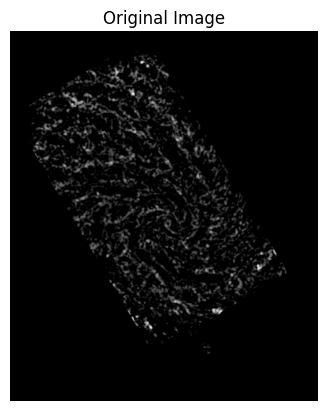

<class 'numpy.uint16'>


True

In [2]:

#Simulated galaxy file
# fits_file = r"C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\galaxysim_SigmaHI_scaledecomposed_intensitytransformed\galaxysim_SigmaHI_CDDss0016pc_arcsinh0p1.fits"

#Actual galaxy file
# fits_file = r"C:\Users\HP\Downloads\ngc4254_F770W_starsub_anchored_CDDss0064pc_arcsinh0p1.fits"

fits_file = r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\ngc0826_divRMS_block4"
#Plot
hdul = fits.open(fits_file)
image_data = np.array(hdul[0].data)/16  # Assuming the image data is in the primary HDU
# image_data = image_data.astype(np.float16)
# image_data = image_data.ravel()
# plt.hist(image_data, bins = 1000)

# plt.hist(image_data.ravel(), bins=256, range=(0.0, 1000000), fc='k', ec='k')
# plt.yscale("log")
image_float = image_data
image_scaled = (image_float - image_float.min()) / (image_float.max() - image_float.min())  # Normalize to [0, 1]
image_uint16 = (image_scaled * 65535).astype(np.uint16)  # Scale to [0, 65535] and convert to uint16
image_data = image_uint16
print(np.max(image_data))
plt.imshow(np.flipud(image_data), cmap = 'gray')
plt.title('Original Image')
plt.axis('off')  
plt.show()
print(type(image_data[0,0]))
input_image = r"C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ngc4254_16bit64pc1_block4.png"
cv2.imwrite(input_image, np.flipud(image_data))

c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\Identification\IdentificationFuncs.py:16: RuntimeWarning: invalid value encountered in cast
  mask_copy = mask_copy.astype(np.uint8)


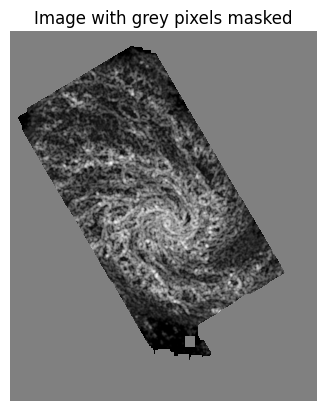

In [3]:
importlib.reload(identify)

# threshold for pixel values to mask
# threshold = .05 # for simulated image
# iters = 6 # for simulated image
# kernel_size = 9 #for simulated image

threshold = .001 # for real image
iters = 6 #for real image
kernel_size = 11
dilated_data, mask = identify.dilateBlankRegions(image_data, threshold, iters, kernel_size) #increase iters or kernel for more aggressive dilation of masked region


In [5]:
importlib.reload(identify)

data = copy.deepcopy(image_data.astype(np.float64)) #photutils should take float64

#subtract bkg
scalepix = 6.4 #16pc/(10pc/pix)
bkg_estimator = MedianBackground()
bkg = Background2D(data, box_size=round(10.*scalepix/2.)*2+1, coverage_mask = mask,filter_size=(3,3), bkg_estimator=bkg_estimator) #Very different RMS with mask. Minimum is MUCH larger
data -= bkg.background #subtract bkg
data[data < 0] = 0 #Elimate neg values. This is over estimating the background and messes up fits files

#scale the bkg subtracted data
topval=np.nanpercentile(data[data!=0],99.999)
datascl=data*65535/topval

#save scaled data to png
datascl = datascl.astype(np.uint16)
input_image = r"C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ngc4254_16bit64pc1.png"
# cv2.imwrite(input_image, datascl)
cv2.imwrite(input_image, np.flipud(datascl))


#save scaled data to fits
fits_file_path =  fr'C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\ngc4254_16bit64pc1.fits'
fits.writeto(fits_file_path, datascl, overwrite=True)

#scaled data stats: 
meanval,medianval,stddevval= sigma_clipped_stats(datascl[datascl!=0],sigma=3,maxiters=None)
print(medianval,stddevval)

#bkg sub/RMS map
noise = bkg.background_rms
noise[noise == 0] = 10**-10 #replace with small number...if noise = 0, we are in background, and output will be set to 0 anyway in two lines

divRMS = data/noise
divRMS[mask] = 0 #masked regions are zero...can change to some reasonable value but doesn't really matter for SOAX


#scale divRMS
topval=np.max(divRMS)
divRMSscl=divRMS*65535/topval
# divRMSscl = identify.normalize_image(divRMS)

#print stats
print(f'RMS max: {np.max(noise)}, RMS min excluding masked pixels: {np.min(noise[noise != 10**-10])} ') #min and max are different than those on google collab...why?
print(f'bkg_sub/RMS max: {np.max(divRMSscl)}, bkg_sub/RMS min excluding 0: {np.min(divRMSscl)}, median: {np.median(divRMSscl)} ') #min and max are different than those on google collab...why?

#save image
fits_file_path =  fr'C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\ngc4254_16bit64pc1_divRMSMap.fits'
fits.writeto(fits_file_path, divRMSscl, overwrite=True)
divRMS = [x for x in divRMS.flatten() if x != 0]

print(f'DivRMS Stats. Mean: {np.mean(divRMSscl)}, std: {np.std(divRMSscl)}, max: {np.max(divRMSscl)}')
#bkg map
fits_file_path =  fr'C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\ngc4254_16bit64pc1bkgMap.fits'
fits.writeto(fits_file_path, bkg.background, overwrite=True)

#RMS map
fits_file_path =  fr'C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\ngc4254_16bit64pc1pcRMSMap.fits'
fits.writeto(fits_file_path, bkg.background_rms, overwrite=True)

print("DONE!")

NameError: name 'mask' is not defined

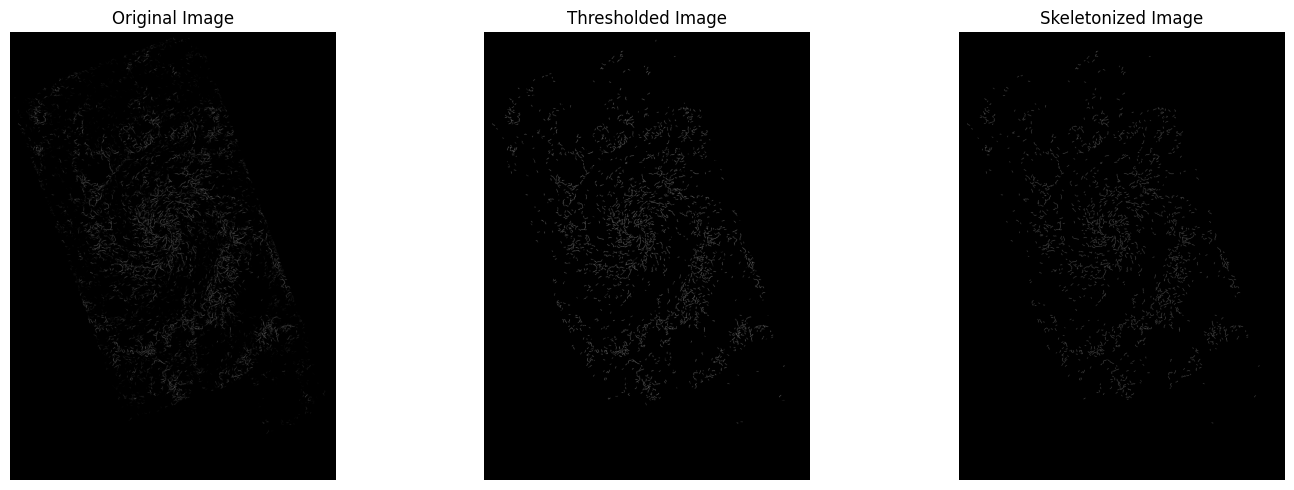

In [4]:
import ImageAnalysis as IA

fits_file = r"C:\Users\HP\Documents\JHU_Academics\Research\Soax_results_blocking_V2\ngc0628CompositeLines\ngc0628_F770W_starsub_anchored_CDDss0008pc_arcsinh0p1.fits_Composite.fits"
#Plot
hdul = fits.open(fits_file)
original_header = hdul[0].header
image_data = np.array(hdul[0].data) / 16  # Normalize if necessary

# Thresholding
_, thresh1 = cv2.threshold(image_data, 7, 255, cv2.THRESH_BINARY)

# Skeletonize the thresholded image
skeleton_image = skeletonize(thresh1 > 0).astype(np.uint8)  # Convert to binary for skeletonize

labels, stats, num_labels = IA.identify_connected_components(np.array(skeleton_image))
small_areas = IA.sort_label_id(num_labels, stats, 25)
img = np.array(skeleton_image)

for label_id in small_areas:
    # Extract the bounding box coordinates
    left = stats[label_id, cv2.CC_STAT_LEFT]
    top = stats[label_id, cv2.CC_STAT_TOP]
    width = stats[label_id, cv2.CC_STAT_WIDTH]
    height = stats[label_id, cv2.CC_STAT_HEIGHT]
    for x in range(width):
        for y in range(height):
            img[top:top+height, left:left+width] = 0

skeleton_image = img


# Plotting the images side-by-side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image_data, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(thresh1, cmap='gray')
axes[1].set_title('Thresholded Image')
axes[1].axis('off')

axes[2].imshow(skeleton_image, cmap='gray')
axes[2].set_title('Skeletonized Image')
axes[2].axis('off')

plt.tight_layout()
plt.show()


skeleton_image = skeleton_image.astype(np.uint16)
fits_file_path =  fr'C:\Users\HP\Documents\JHU_Academics\Research\Soax_results_blocking_V2\256ngc0628Skel.fits'
hdu = fits.PrimaryHDU(skeleton_image, header=original_header)  
hdu.writeto(fits_file_path, overwrite=True)



Set DATE-AVG to '2022-07-17T12:01:53.586' from MJD-AVG.
Set DATE-END to '2022-07-17T12:54:46.016' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -37.754891 from OBSGEO-[XYZ].
Set OBSGEO-H to 1738895745.206 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


points in output: 321.0, expected points: 324
(2600, 1891)


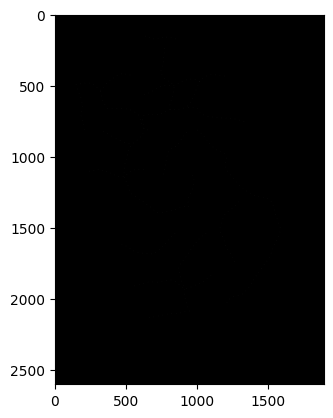

In [41]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Path to CSV containing coordinates
csv_file_path = r"C:\Users\HP\Documents\JHU_Academics\Research\Soax_results_blocking_V2\ngc0628\SOAXOutput\256pc\best_param7\ngc0628_F770W_starsub_anchored_CDDss0256pc_arcsinh0p1.fits_Blocked--ridge0.02750--stretch2.000.txt_to_CSV.csv"
# Load the original FITS file and its WCS
original_fits_file = r"C:\Users\HP\Documents\JHU_Academics\Research\Soax_results_blocking_V2\ngc0628\BkgSubDivRMS\ngc0628_F770W_starsub_anchored_CDDss0256pc_arcsinh0p1.fits_divRMS.fits"
with fits.open(original_fits_file) as hdul_orig:
    wcs_orig = WCS(hdul_orig[0].header)
    image_data = np.array(hdul_orig[0].data)  # Assuming the image data is in the primary HDU
    original_header = hdul_orig[0].header

# Load the blocked FITS file and its WCS
blocked_fits_file = r"C:\Users\HP\Documents\JHU_Academics\Research\Soax_results_blocking_V2\ngc0628\SOAXOutput\256pc\best_param7\ngc0628_F770W_starsub_anchored_CDDss0256pc_arcsinh0p1.fits_Blocked--ridge0.02750--stretch2.000.txt_to_FITS.fits"
with fits.open(blocked_fits_file) as hdul_blocked:
    wcs_blocked = WCS(hdul_blocked[0].header)

# Read CSV to get coordinates
df = pd.read_csv(csv_file_path)
x_coords = pd.to_numeric(df["x"], errors="coerce")
y_coords = pd.to_numeric(df["y"], errors="coerce")

# Drop NaN values
coords = pd.DataFrame({"x": x_coords, "y": y_coords}).dropna()

# Step 1: Convert blocked image coordinates to world coordinates (RA, Dec)
world_coords = wcs_blocked.pixel_to_world(coords["x"], coords["y"])

# Step 2: Convert world coordinates to pixel coordinates in the original image
x_original, y_original = wcs_orig.world_to_pixel(world_coords)

# Initialize an empty image to store the mapped coordinates
gray_image = np.zeros_like(image_data)

# Filter out NaN coordinates and ensure coordinates are valid
coordinates = [(x, y) for x, y in zip(x_original, y_original) if not (np.isnan(x) or np.isnan(y))]

count = 0
# Ensure coordinates are within the image bounds
for (x, y) in coordinates:
    x = int(round(x))  # Round to nearest integer
    y = int(round(y))  # Round to nearest integer
    if 0 <= x < gray_image.shape[1] and 0 <= y < gray_image.shape[0]:
        gray_image[y, x] = 1  # Mark the pixel as 1
    else: 
        count+=1
        print(count)

# Print statistics about the number of points mapped
print(f"points in output: {np.sum(gray_image)}, expected points: {len(coordinates)}")
print(np.shape(gray_image))
# Display the final image
plt.imshow(gray_image, cmap="gray")
plt.show()

# Save the output image as a FITS file
path = r"C:\Users\HP\Documents\JHU_Academics\Research\Soax_results_blocking_V2\256Vertexngc0628.fits"
hdu = fits.PrimaryHDU(gray_image, header=original_header)
hdu.writeto(path, overwrite=True)


In [26]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import pandas as pd

# Path to CSV containing coordinates
csv_file_path = r"C:\Users\HP\Documents\JHU_Academics\Research\Soax_results_blocking_V2\GalaxySim\SOAXOutput\256pc\galaxysim_SigmaHI_CDDss0256pc_arcsinh0p1.fits_Blocked--ridge0.02500--stretch3.500.txt_to_CSV.csv"

# Load the original FITS file and its WCS
original_fits_file = r"C:\Users\HP\Documents\JHU_Academics\Research\Soax_results_blocking_V2\GalaxySim\BkgSubDivRMS\galaxysim_SigmaHI_CDDss0256pc_arcsinh0p1.fits_divRMS.fits"
with fits.open(original_fits_file) as hdul_orig:
    wcs_orig = WCS(hdul_orig[0].header)
    image_data = np.array(hdul_orig[0].data)  # Assuming the image data is in the primary HDU

# Load the blocked FITS file and its WCS
blocked_fits_file = r"C:\Users\HP\Documents\JHU_Academics\Research\Soax_results_blocking_V2\GalaxySim\SOAXOutput\256pc\galaxysim_SigmaHI_CDDss0256pc_arcsinh0p1.fits_Blocked--ridge0.02500--stretch3.500.txt_to_FITS.fits"
with fits.open(blocked_fits_file) as hdul_blocked:
    wcs_blocked = WCS(hdul_blocked[0].header)

# Read CSV to get coordinates
df = pd.read_csv(csv_file_path)
x_coords = pd.to_numeric(df["x"], errors="coerce")
y_coords = pd.to_numeric(df["y"], errors="coerce")

# Drop NaN values
coords = pd.DataFrame({"x": x_coords, "y": y_coords}).dropna()

# Step 1: Convert blocked image coordinates to world coordinates (RA, Dec)
world_coords = wcs_blocked.pixel_to_world(coords["x"], coords["y"])

# Step 2: Convert world coordinates to pixel coordinates in the original image
x_original, y_original = wcs_orig.world_to_pixel(world_coords)

# Prepare region file content
region_file_content = []

# Filter out NaN coordinates and ensure coordinates are valid
valid_coordinates = []
for x, y in zip(x_original, y_original):
    # Check for NaN and out-of-bounds
    if np.isnan(x) or np.isnan(y):
        print(f"Skipping NaN coordinate: x={x}, y={y}")
    else:
        # Ensure the coordinates are within the bounds of the image
        if 0 <= x < image_data.shape[1] and 0 <= y < image_data.shape[0]:
            valid_coordinates.append((x, y))
        else:
            print(f"Skipping out-of-bounds coordinate: x={x}, y={y}")

# Format coordinates for DS9 region file (circle format)
for x, y in valid_coordinates:
    x = int(round(x))  # Round to nearest integer
    y = int(round(y))  # Round to nearest integer
    region_file_content.append(f"circle({x}, {y}, 1.)")  # Add circle with radius 1

# Check how many valid coordinates were found
print(f"Found {len(valid_coordinates)} valid coordinates.")

# Write the DS9 region file
region_file_path = r"C:\Users\HP\Documents\JHU_Academics\Research\Soax_results_blocking_V2\GalaxySim\SOAXOutput\256Vertex.reg"
with open(region_file_path, "w") as reg_file:
    reg_file.write("# Region file format: DS9\n")
    reg_file.write("global color=green width=1 font='helvetica 10' select=1 highlite=1 dash=0 fixed=0\n")
    reg_file.write("fk5\n")  # Assuming the coordinates are in the FK5 system
    for region in region_file_content:
        reg_file.write(region + "\n")

print(f"DS9 region file written to: {region_file_path}")


Found 619 valid coordinates.
DS9 region file written to: C:\Users\HP\Documents\JHU_Academics\Research\Soax_results_blocking_V2\GalaxySim\SOAXOutput\256Vertex.reg


Set DATE-AVG to '2022-07-17T12:01:53.586' from MJD-AVG.
Set DATE-END to '2022-07-17T12:54:46.016' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -37.754891 from OBSGEO-[XYZ].
Set OBSGEO-H to 1738895745.206 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [ ]:

# print('starting 1 64 Real')

# subprocess.run([
#     r"C:\Users\HP\Downloads\batch_soax_v3.7.0.exe",  # Executable path
#     "soax",  # Command argument
#     "-i", r"C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ngc0628_16bit64pc1.png",  # Input image path
#     "-p", r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_params\best_param1_64pc.txt",  # Parameters file path
#     "-s", r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param1_64pc_Real",  # Results folder path
#     "--ridge", "0.005", "0.005", "0.025",  # Ridge parameters
#     "--stretch", "2.0", "0.5", "4.0"  # Stretch parameters
# ])

# print('starting 2 64 Real')

# subprocess.run([
#     r"C:\Users\HP\Downloads\batch_soax_v3.7.0.exe",  # Executable path
#     "soax",  # Command argument
#     "-i", r"C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ngc0628_16bit64pc1.png",  # Input image path
#     "-p", r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_params\best_param2_64pc.txt",  # Parameters file path
#     "-s", r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param2_64pc_Real",  # Results folder path
#     "--ridge", "0.005", "0.015", "0.05",  # Ridge parameters
#     "--stretch", "3.0", "0.5", "3.5"  # Stretch parameters
# ])

print('starting 2 64 Real')

subprocess.run([
    r"C:\Users\HP\Downloads\batch_soax_v3.7.0.exe",  # Executable path
    "soax",  # Command argument
    "-i", r"C:\Users\HP\Documents\JHU_Academics\Research\Soax_results_blocking\ngc0628\BlockedPng\ngc0628_F770W_starsub_anchored_CDDss0256pc_arcsinh0p1.fits_Blocked.png",  # Input image path
    "-p", r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_params\best_param1_16pc.txt",  # Parameters file path
    "-s", r"C:\Users\HP\Documents\JHU_Academics\Research",  # Results folder path
    "--ridge", "0.020", "0.005", "0.035",  # Ridge parameters
    "--stretch", "3.0", "0.5", "4.0"  # Stretch parameters
])

# print('starting 4 64 Real')

# subprocess.run([
#     r"C:\Users\HP\Downloads\batch_soax_v3.7.0.exe",  # Executable path
#     "soax",  # Command argument
#     "-i", r"C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ngc0628_16bit64pc1.png",  # Input image path
#     "-p", r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_params\best_param4_64pc.txt",  # Parameters file path
#     "-s", r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param4_64pc_Real",  # Results folder path
#     "--ridge", "0.005", "0.015", "0.05",  # Ridge parameters
#     "--stretch", "3.0", "0.5", "3.5"  # Stretch parameters
# ])

# print('starting 7 64 Real')

# subprocess.run([
#     r"C:\Users\HP\Downloads\batch_soax_v3.7.0.exe",  # Executable path
#     "soax",  # Command argument
#     "-i", r"C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ngc0628_16bit64pc1.png",  # Input image path
#     "-p", r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_params\best_param7_64pc.txt",  # Parameters file path
#     "-s", r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param7_64pc_Real",  # Results folder path
#     "--ridge", "0.005", "0.005", "0.025",  # Ridge parameters
#     "--stretch", "2.0", "0.5", "4.0"  # Stretch parameters
# ])

# print('starting 8 64 Real')

# subprocess.run([
#     r"C:\Users\HP\Downloads\batch_soax_v3.7.0.exe",  # Executable path
#     "soax",  # Command argument
#     "-i", r"C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ngc0628_16bit64pc1.png",  # Input image path
#     "-p", r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_params\best_param8_64pc.txt",  # Parameters file path
#     "-s", r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param8_64pc_Real",  # Results folder path
#     "--ridge", "0.005", "0.015", "0.05",  # Ridge parameters
#     "--stretch", "3.0", "0.5", "3.5"  # Stretch parameters
# ])


starting 2 64 Real


CompletedProcess(args=['C:\\Users\\HP\\Downloads\\batch_soax_v3.7.0.exe', 'soax', '-i', 'C:\\Users\\HP\\Documents\\JHU_Academics\\Research\\Soax_results_blocking\\ngc0628\\BlockedPng\\ngc0628_F770W_starsub_anchored_CDDss0512pc_arcsinh0p1.fits_Blocked.png', '-p', 'C:\\Users\\HP\\Documents\\JHU_Academics\\Research\\SOAX_results\\best_params\\best_param1_16pc.txt', '-s', 'C:\\Users\\HP\\Documents\\JHU_Academics\\Research', '--ridge', '0.020', '0.005', '0.035', '--stretch', '3.0', '0.5', '4.0'], returncode=0)

In [27]:
input_image = input_image #taken from above

batch = r"C:\Users\HP\Downloads\batch_soax_v3.7.0.exe"
# param_dir = r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX\Output\Parameter_files"
param_dir = r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_params"

for param_file in os.listdir(param_dir):
    # Use numpy.arange() to generate floating-point values
    # Split the file name into base name and extension
    base_name, extension = os.path.splitext(param_file)

    # Print the base name without extension
    # output_dir = fr"C:\Users\HP\Documents\JHU_Academics\Research\SOAX\Output\results\{base_name}"
    output_dir = fr"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\{base_name}"

    assert(os.path.isdir(output_dir))
    # parameter_file = fr"C:\Users\HP\Documents\JHU_Academics\Research\SOAX\Output\Parameter_files\{param_file}"
    parameter_file = fr"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_params\{param_file}"

    assert( os.path.isfile(parameter_file))
    assert( os.path.isfile(input_image))

    print("starting")
    cmdString = f'"{batch}" soax -i "{input_image}" -p "{parameter_file}" -s "{output_dir}" --ridge 0.025 0.01 0.055 --stretch 3.0 0.5 4'
    print(cmdString)
    # subprocess.run(cmdString, shell=True)  # Use shell=True if command needs shell features
    print(f'{param_file} complete')


AssertionError: 

In [10]:
import subprocess
import pandas as pd 


result_dir = r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results"
# Define the expected header line for identification
expected_header = "s p x y z fg_int bg_int"

for result_folder in os.listdir(result_dir):
    result_folder = os.path.join(result_dir, result_folder)
    for result_file in os.listdir(result_folder):
        if(result_file.endswith('.txt')):
            input_file_path = os.path.join(result_folder, result_file)
            print(f' wprking on {input_file_path}')
            assert( os.path.isfile(input_file_path))
            
            base_name, extension = os.path.splitext(input_file_path)
            output_file_path = output_dir = fr'{result_folder}\{result_file}To_csv.csv'

            # Read the content of the input file
            with open(input_file_path, 'r') as file:
                lines = file.readlines()

            # Find the index where the header starts
            header_start_index = None
            for i, line in enumerate(lines):
                # Normalize line by stripping extra spaces
                normalized_line = ' '.join(line.split())

                if normalized_line == expected_header:
                    header_start_index = i
                if "[" in line:
                    stopper_index = i
                    break

            if header_start_index is None:
                print('HEADER NOT FOUND!')
                continue

            # Extract header and data
            header_and_data = lines[header_start_index:stopper_index]

            # Write to CSV
            with open(output_file_path, 'w', newline='') as csvfile:
                csv_writer = csv.writer(csvfile)
                
                for line in header_and_data:
                    # Split columns by whitespace (assuming whitespace is the delimiter)
                    row = line.split()
                    csv_writer.writerow(row)

            # print(f"{result_file} has been saved to {output_file_path}")

            df = pd.read_csv(output_file_path)
            # print(df.head(10))
            # Convert coordinates to float
            x_coords = pd.to_numeric(df["x"], errors="coerce")
            # Remove NaN values

            y_coords = pd.to_numeric(df["y"], errors="coerce")
            # Remove NaN values

            coords = pd.DataFrame({"x": x_coords, "y": y_coords}).dropna()

            # Now you can safely round and convert both x and y together
            x_coords_cleaned = [int(round(x)) for x in coords["x"]]
            y_coords_cleaned = [int(round(y)) for y in coords["y"]]

            assert(len(x_coords_cleaned)==len(y_coords_cleaned))
            coordinates = list(zip(x_coords_cleaned,y_coords_cleaned))


            gray_image = np.zeros_like(image_data)
            # Step 3: Color the coordinates purple
            # Ensure coordinates are within the image bounds
            for (y,x) in coordinates:
                if 0 <= x < gray_image.shape[0] and 0 <= y < gray_image.shape[1]:
                    gray_image[x, y] = 1

            # fits.writeto(fits_file_path, gray_image, overwrite=True)
            # print(f'fits saved to {fits_file_path}')

            #get dictionary for filaments
            filament_dict = {}

            # Grouping the coordinates
            for index, row in df.iterrows():
                s_value = row['s']
                if "#" not in s_value:
                    s_value = int(s_value)   
                    if s_value not in filament_dict:
                        filament_dict[s_value] = []  # Initialize the list for this s value
                    # Append the (x, y) coordinates as a tuple
                    filament_dict[s_value].append((row['x'], row['y']))
            # t = .008
            # c = 5
            # F, modF = identify.computeF(filament_dict, noise, gray_image, t, c)
            # print(identify.computeF(filament_dict, noise, gray_image, t, c))

            fits_file_path = fr'{result_folder}\{result_file}to_fits.fits'
            fits.writeto(fits_file_path, np.flipud(gray_image), overwrite=True)

            print('Success')
    

 wprking on C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param1_64pc_Real\ngc0628_16bit64pc1--ridge0.005000--stretch2.000.txt
Success
 wprking on C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param1_64pc_Real\ngc0628_16bit64pc1--ridge0.005000--stretch2.500.txt
Success
 wprking on C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param1_64pc_Real\ngc0628_16bit64pc1--ridge0.005000--stretch3.000.txt
Success
 wprking on C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param1_64pc_Real\ngc0628_16bit64pc1--ridge0.005000--stretch3.500.txt
Success
 wprking on C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param1_64pc_Real\ngc0628_16bit64pc1--ridge0.01000--stretch2.000.txt
Success
 wprking on C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param1_64pc_Real\ngc0628_16bit64pc1--ridge0.01000--stretch2.500.txt
Success
 wprking on 

NotADirectoryError: [WinError 267] The directory name is invalid: 'C:\\Users\\HP\\Documents\\JHU_Academics\\Research\\SOAX_results\\best_results\\GalaxySim16pc_Thresh.fits'

In [16]:
importlib.reload(identify)
t = .008
c = 5
print(identify.computeF(filament_dict, noise, gray_image, t, c))

(530296.0, 530259.4136636637)
